Let's examine our Google Colab runtime. What kind of GPU and CPU did we get?

In [ ]:
!nvidia-smi

In [ ]:
!lscpu

# Convolutional Neural Network

This notebook follows along with the lecture on your first DNN.

For this lecture we're going to use the MNIST data set (link). This is a set of 28x8 grayscale images o single digits 0 to 9.

We're going to examine 3 network models. The first is a FCN (Fully Connected Network). The second is simple convolutional model. The third is a more complicated CNN.

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.4.1
Number of GPUs Available:  1


In [4]:
# import tf.keras as keras
print(tf.keras.__version__)

2.4.0


In [ ]:
%matplotlib inline

---

## MNIST Data Set

The first model borrows from what we learned in the First NN lecture. It is a simple FCN model. To see what the MNIST dataset looks like, we can load the data set and plot the first 4 images of the training set.

Note that the data set is stored in an AWS S3 bucket so when you first download it, it might take a few minutes.

Also not that you may have to run the call below twice to get the images to appear.

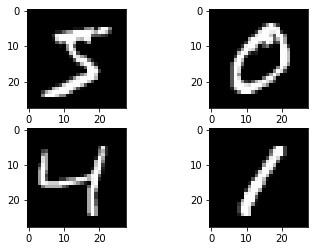

In [6]:
# Plot ad hoc mnist instances
import tensorflow as tf
import matplotlib.pyplot as plt

# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

## FCN Model

Let's use a fixed random number seed for reproducibility.

In [7]:
# fix random seed for reproducibility
import numpy

seed = 7
numpy.random.seed(seed)

Next, load the data into the training data set and the test data set.

In [8]:
# load data
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

We need to flatten the images (they are 2D) into a 1D vector to use a FCN model. 

In [9]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

Let's normalize the input since we kwow it has to range from 0 to 255.

In [10]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

A one hot encode is needed since we have more than one class. This puts each output from 0 to 1.

In [11]:
# one hot encode outputs
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
num_classes = y_test.shape[1]


The model is defined in a routine for this code.

In [12]:
import tensorflow as tf

# define baseline model
def baseline_model():
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal',
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model
# end def

Finaly we can create the model, train it, compute the final scores, and print the first one (as a check).

In [13]:
# build the model
model = baseline_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
300/300 - 1s - loss: 0.2753 - accuracy: 0.9217 - val_loss: 0.1345 - val_accuracy: 0.9610
Epoch 2/10
300/300 - 1s - loss: 0.1107 - accuracy: 0.9684 - val_loss: 0.0997 - val_accuracy: 0.9692
Epoch 3/10
300/300 - 1s - loss: 0.0708 - accuracy: 0.9796 - val_loss: 0.0838 - val_accuracy: 0.9743
Epoch 4/10
300/300 - 1s - loss: 0.0505 - accuracy: 0.9852 - val_loss: 0.0727 - val_accuracy: 0.9782
Epoch 5/10
300/300 - 1s - loss: 0.0372 - accuracy: 0.9894 - val_loss: 0.0699 - val_accuracy: 0.9776
Epoch 6/10

You can create the entire code by combining the previous cells.

---

## Simple Convolutional Model

A convolutional Model will require additional modules to load. Again, let's use a
fixed random number seed for reproducibility.

In [1]:
# fix random seed for reproducibility
import numpy

seed = 7
numpy.random.seed(seed)

Load the data set and reshape the input so that it can be loaded correctly. It also allows you to adjust to the FP32 data type which is the default or Keras.

In [2]:
import tensorflow as tf
# load data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

11493376/11490434 [==============================] - 0s 0us/step


The inputs are normalized (0 to 255) and the outputs are one hot encoded (more than one class)

In [3]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
num_classes = y_test.shape[1]

The model is again created in a routine. Notice the new layers (conv2D) as well as softmax decode layer.

In [4]:
def baseline_model():
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5, 5), input_shape=(1, 28, 28), data_format = 'channels_first',
                                     activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model
# end def


Finaly we can create the model, train it, compute the final scores, and print the first one (as a check).

In [5]:
# build the model
model = baseline_model()

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

# To fix problem:
# https://github.com/keras-team/keras/issues/7611
# https://stackoverflow.com/questions/45645276/negative-dimension-size-caused-by-subtracting-3-from-1-for-conv2d-2-convolution/45647715#45647715


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 24, 24)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 12, 24)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 12, 24)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 592,074
Trainable params: 592,074
Non-trainable params: 0
__________________________________________________

Runs slower. A little bit smaller error.

---

## More comprehensive Convolution

The simple convolution got better accuracy than FCN for the same number of epochs. Let's add some more conv2D layers to see if accuracy is improved.

The first steps are combined below.

In [ ]:
# Larger CNN for the MNIST Dataset
import numpy
import tensorflow as tf

#from keras.datasets import mnist
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import Dropout
#from keras.layers import Flatten
#from keras.layers.convolutional import Conv2D
#from keras.layers.convolutional import MaxPooling2D
#from keras.utils import np_utils
#from keras import backend as K
#K.set_image_dim_ordering('th')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In the routine for defining model, notice we've added a 2D pooling layer and another FCN layer.

In [ ]:
# define the larger model
def larger_model():
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(30, (5, 5), input_shape=(1, 28, 28), data_format = 'channels_first',
                                     activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(15, (3, 3), data_format = 'channels_first', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model
# end def

Finaly we can create the model, train it, compute the final scores, and print the first one (as a check).

In [ ]:
# build the model
model = larger_model()

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Notice that the error (loss) is better than both of the previous networks.

In [ ]:
# Larger CNN for the MNIST Dataset
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt

#from keras.datasets import mnist
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import Dropout
#from keras.layers import Flatten
#from keras.layers.convolutional import Conv2D
#from keras.layers.convolutional import MaxPooling2D
#from keras.utils import np_utils
#from keras import backend as K
#import matplotlib.pyplot as plt
#K.set_image_dim_ordering('th')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# define the larger model
def larger_model():
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(30, (5, 5), input_shape=(1, 28, 28), data_format = 'channels_first',
                                     activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(15, (3, 3), data_format = 'channels_first', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model
# end def

# build the model
model = larger_model()

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)

# Evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))
print(" ")

# Inference on random image
img_class = model.predict_classes(X_test)

prediction = img_class[130]
print("X_test[130] = ",prediction)

img = X_test[130]
test_img = img.reshape((1,784))

img = img.reshape((28,28))
plt.imshow(img)
plt.title(str(prediction))
plt.show()